# 11.프로젝트: 한국어 데이터로 챗봇 만들기
##### !. Google Colab Pro에서 작성 되었습니다.


### 목차
STEP 0. 주요 라이브러리 import.  
STEP 1. 데이터 수집하기  
STEP 2. 데이터 전처리하기  
STEP 3. SubwordTextEncoder 사용하기  
STEP 4. 모델 구성하기  
STEP 5. 모델 평가하기  
회고록   
Reference

---

### (본문)

### STEP 0: 주요 라이브러리 import

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("주요라이브러리 import 완료")

주요라이브러리 import 완료


### STEP 1: 데이터 수집하기

한국어 챗봇 데이터는 송역숙님 공개한 챗봇 데이터를 사용.  
link: https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv  
질문에 챗봇이 위로한다는 취지로 답변을 작성  
챗봇 트레이닝용 문답 페이 11,823개  
일상다반사(중립) 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링  
중립 0: 5290개  
부정 1: 3570개  
긍정 2: 2963개  
결측치 없음  

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/E_11_transformer/ChatbotData.csv')

In [69]:
%%capture
data

총 11823열의 한국어 문답 데이터가 담겨 있는 파알  
데이터가 길기에 %%caoutre을 사용하여 생략

### STEP 2: 데이터 전처리하기

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듬.
    # 예를 들어서 "안녕하세요." => "안녕하세요  ."와 같이
    # student와 온점 사이에 거리를 만듬.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
  
    # 한글을 제외한 모든 문자를 공백인 ' '로 대체.
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [9]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))
    return inputs, outputs

In [10]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [11]:
print('전처리 후의 15번째 질문 샘플: {}'.format(questions[16]))
print('전처리 후의 15번째 답변 샘플: {}'.format(answers[16]))

전처리 후의 15번째 질문 샘플: 가상화폐 쫄딱 망함
전처리 후의 15번째 답변 샘플: 어서 잊고 새출발 하세요 .


### STEP 3: SubwordTextEncoder 사용하기

단어장(Vocabulary) 만들기

In [12]:
import tensorflow_datasets as tfds
print("실행시간 long take")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("데이터 셋 생성 완료")

실행시간 long take
데이터 셋 생성 완료


In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("시작, 종료 토근 고유 정수 부여 완료")


시작, 종료 토근 고유 정수 부여 완료


In [14]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])


START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [15]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [16]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


In [17]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [19]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


교사 강요(Teacher Forcing) 사용하기

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용.
# 이에 따라 outputs에서는 START_TOKEN을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### STEP 4: 모델 구성하기

#### Transformer 모델 구현

포지셔널 행렬 구하기  
트랜스포머는 사인 함수, 코사인 함수 값을 임베딩 벡터에 더함(=단어의 순서 정보를 더함)  
트랜스포머는 문장 단위로 입력받기 때문에 어순 정보가 필요.  

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

어텐션

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듬.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수.
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate).
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용.
    outputs = self.dense(concat_attention)

    return outputs

마스킹

In [26]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [28]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더

In [30]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션).
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행.
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션).
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행.
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층.
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

트랜스포머 함수 정의

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용.
  # 내부적으로 패딩 마스크도 포함되어져 있음.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

모델 생성

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3135232     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

손실 함수

In [34]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


커스텀 학습률

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

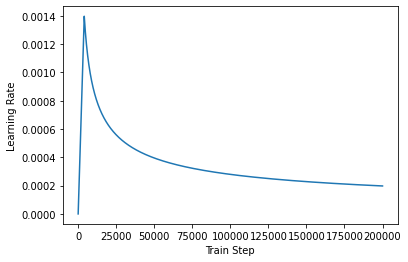

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

모델 컴파일

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련 100으로 설정

In [38]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 19s 55ms/step - loss: 1.4454 - accuracy: 0.0309
Epoch 2/100
185/185 [==============================] - 10s 55ms/step - loss: 1.1740 - accuracy: 0.0494
Epoch 3/100
185/185 [==============================] - 11s 58ms/step - loss: 1.0035 - accuracy: 0.0505
Epoch 4/100
185/185 [==============================] - 11s 57ms/step - loss: 0.9276 - accuracy: 0.0543
Epoch 5/100
185/185 [==============================] - 10s 56ms/step - loss: 0.8688 - accuracy: 0.0578
Epoch 6/100
185/185 [==============================] - 10s 55ms/step - loss: 0.8081 - accuracy: 0.0620
Epoch 7/100
185/185 [==============================] - 10s 55ms/step - loss: 0.7426 - accuracy: 0.0679
Epoch 8/100
185/185 [==============================] - 11s 58ms/step - loss: 0.6702 - accuracy: 0.0760
Epoch 9/100
185/185 [==============================] - 11s 60ms/step - loss: 0.5915 - accuracy: 0.0845
Epoch 10/100
185/185 [==============================] - 11s 59ms/step - l

### STEP 5: 모델 평가하기

#### Step 1에서 선택한 전처리 방법을 고려하여 입력된문장에 대해서 대답을 얻는 예측함수를 만듬.

In [39]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가.
    # 이 output_sequence는 다시 디코더의 입력.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

모델 평가용 입력 문장리스트 & 함수

In [75]:
input_question_8 = [
    "배고파",
    "저녁 뭐 먹지?",
    "여행 가고싶어",
    "요즘 너무 피곤해",
    "비가 내리네",
    "기다려",
    "인생이란 무엇일까",
    "명언 아무거나 말해줘"
]


In [74]:
def print_transformer_Q_A(input_question_8):
    for input_qusetion in input_question_8:
        sentence_generation(input_qusetion)
        print()

#### 답변 모음

In [76]:
print_transformer_Q_A(input_question_8)

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .

입력 : 저녁 뭐 먹지?
출력 : 맛있는 거 드세요 .

입력 : 여행 가고싶어
출력 : 가면 저도 데려가세요 .

입력 : 요즘 너무 피곤해
출력 : 푹 쉬세요 .

입력 : 비가 내리네
출력 : 그러게요 . 비가 추적추적 내려요 .

입력 : 기다려
출력 : 상대방에게 너무 무거운 짐을 주지 마세요 .

입력 : 인생이란 무엇일까
출력 : 서로 더 많이 아껴주세요 .

입력 : 명언 아무거나 말해줘
출력 : 나 자신에 집중하세요 . 언제나 순위에 자신을 두세요 .



질문에 맞는 적절한 대답을 하는 것처럼은 보임  
현재 비가 내리지 않음에도 비가 내린다고 답변(상황 파악을 하지 못하는 것으로 보임)  
앞서 말한 대답과 반대되는 답변(전후 맥락을 기억하지 못하는 것으로 보임)  


---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다. | |공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다. | |
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. | |구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다. | |
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. | |한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다. | |

---

### 회고록.

질문과 답변이라는 대화의 원리를 응용한 데이터를 사용하여 Transformer 모델을 기반으로 한 인코더-디코더 구조 그리고 어텐션을 이해해 코드로 구현해 스마트한 한국어 챗봇을 만들어보는 11번째 Exploration 프로젝트였다.  
과거 챗봇들은 지정한 질문을 제외한 대답들에 대해 오로지 '대답할 수 없습니다'밖에 하지 못해다.   
어떻게 보면 딱딱하게 느껴지고 인간적으로 봤을 때 수동적, 자유도가 없어 보인다고 말할 수 있을 것이다.     
이번 프로젝트에서의 챗봇은 어떤 질문에도 가장 큰 연관을 보이는 답변을 찾아내어 어떠한 문장이든(설령 그게 생뚱맞은 대답일지라도)출력하여 자유롭지만 그렇다고 아무 말이나 하는 것은 아닌 그 중간을 한국어로 구현하는 것이 목표였는데 사실 그리 만족스럽지는 않았다.   
epoch를 낮추거나 높였을 때 문장의 형태는 바뀌지만 epoch가 다르다고(정확히는 일정 수준에 도달한 loss, accuracy가 이후 값이 바뀌어도) 해서 과연 그 대답이 질문에 맞는 대답인가 더 수준 높은 대답인가에 대한 객관적인 평가를 하기 어려웠기 때문이다.   
사람들은 흔히들 교양있는 대화를 한다고 하면 여러 배경지식과 상황에 맞는 매너와 용어들을 사용하거나 상대방에게 깊은 깨달음이나 변화를 주는 문장을 사용한다.  
그러나 현재 이 프로젝트에서 인공지능은 화자의 입장과 상황을 학습하지 못했기에 그냥 자신이 알고 있는 용어들만 내뱉는 것인데, 이를 일반적인 상황에 비유하자면 앞뒤가 꽉막히고 눈치도 없어 자기 할말만 하는 사람과 대화하는 것과 차이가 없는 것처럼 느껴졌다.   
아마도 사람은 상대방과 대화하면서 맥락과 상황에 대해 학습하게 되는데 현재 이 모델은 이러한 상황을 학습하지 못하기 때문일 것이다.  
인공지능의 성능을 더 높이기 위해서 화자의 속성(비슷한 사용자데이터를 갖고온다던지), 상황(대화전에 사용자의 여러 상황을 학습해 사용자의 상황에 맞춘), 그리고 대화하며 화자가 내뱉는 말들에 맞춰서 다른 대답을 꺼낼 수 있도록 실시간으로 문맥을 파악할 수 있도록 한다면 그때는 더 자연스러운 모델을 만들 수 있지 않을까싶다.  


NLP 모델들이 점점 더 많아지고 있음. 각 모델들의 성능 그리고 원리를 깨달아 적절한 한국어 모델링을 직접 구현해볼 수 있는 단계까지 나아가고 싶음. 영어와 한국어의 문법체계가 다르다는 것에 맞춰 모델을 설계하고 '.' 나 ',' 같은 특수문자들도 적절하게 전처리와 학습, 출력해내는 것을 목표로 할 필요가 있음.



----

### Reference. (APA)


유원준 외 1명.(2022). 딥 러닝을 이용한 자연어 처리 입문. 위키독스

트랜스포머(어텐션 이즈 올 유 니드).(2022.06.10). URL: https://www.youtube.com/watch?v=mxGCEWOxfe8&ab_channel=MinsukHeo%ED%97%88%EB%AF%BC%EC%84%9D  


-----